In [1]:
import time, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.special import comb

In [2]:
def gauss(x, b=0, c=1):
    return np.exp(-(x-b)**2/(2*c**2))

def gauss_kx(x, kx, b=0, c=1):
    return gauss(x, b, c) * np.exp(1j * kx * x)

def get_BC_kx(x_0, x_max, x_step, kx, beam_center=0, waist=1):
    BC = [gauss_kx(x, kx, beam_center, waist) for x in np.arange(x_0, x_max, x_step)]
    return np.array(BC)

def smooth(vec, smoothen=10):
    s_vec = np.pad(vec, (smoothen//2, smoothen-smoothen//2), mode='edge')
    return np.cumsum(s_vec[smoothen:] - s_vec[:-smoothen]) / smoothen

In [32]:
def n_to_Veff(n_of_x, k):
    return 0.5 * k * (np.array(n_of_x)**2 - 1)

In [161]:
def n_sqr_well(x, x_star=2.5):
    coef = np.power(0.005, 1/4) / x_star
    if np.abs(x) <= x_star:
        val = 1 + (coef * x)**4
    else:
        val = 1.005
    return val

def n_step(x, a=1):
    return 0.25 * np.tanh(a*x) + 1.25

def n_step_sharp(x, midpoint=0):
    if x < midpoint:
        return 1
    else:
        return 1.5

def moving_avg(vec, smooth_size=5):
    cs = np.cumsum(np.insert(vec, 0, 0)) 
    return (cs[smooth_size:] - cs[:-smooth_size]) / smooth_size

def dEdz_vec(E, x, k, n_of_x, ddx):
    V_eff = n_to_Veff(n_of_x, k)
    return (((-V_eff * E) - ddx/(2*k)) / 1j)

def RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_of_x, smooth_val):
    # list of zvals
    z_list = np.arange(z_0, z_max, z_step)
    
    # list of xvals
    x_list = np.arange(x_0, x_max, x_step)
        
    # grid of E vals starts as just the boundary conditions
    E_grid = [BC]
    
    # loop over z's
    for i in tqdm(range(int((z_max - z_0) / z_step))):
        # 1st derivative
        der_1 = np.gradient(E_grid[i], x_step, edge_order=1)
        
        # 2nd derivative
        der_vals = np.gradient(der_1, x_step, edge_order=1)
        
        # V effective
        v_eff = n_to_Veff(n_of_x, kz)
        
        k1_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals)
        k2_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k1_vec)
        k3_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + 0.5 * k2_vec)
        k4_vec = z_step * dEdz_vec(E_grid[i], x_list, kz, n_of_x, der_vals + k3_vec)
        
        new_slice = E_grid[i] + k1_vec/6 + k2_vec/3 + k3_vec/3 + k4_vec/6
        
        if any([val > 1.1 for val in new_slice]):
            print(i)
            break

        E_grid.append(new_slice)
        
    # 64 bit floats instead of 128 to help memory usage
    return np.array(E_grid, dtype=np.complex64)

In [90]:
def get_angle(k, kx):
    return np.arcsin(kx / k)

def get_kz(k, angle):
    return np.cos(angle) * k

In [143]:
# physical params
lam = 200 * 10**(-3) # micrometers
# lam = 200 * 10**(-9) # meters
k = 2*np.pi/lam

# beam params (micrometers)
beam_center = -4
waist = 1

# spatial params (micrometers)
x_step = 10**(-1)
x_0 = -6
x_max = 6

z_step = 5*10**(-4)
z_0 = 0
z_max = 1*10**(2)
hlim = z_max / z_step

kxs = np.arange(0, 1, 0.02)

angles = get_angle(k, kxs)
kzs = get_kz(k, angles)

x_list = np.arange(x_0, x_max, x_step)

In [155]:
big_angle = 10 * np.pi / 180
big_kx = np.sin(big_angle) * k
big_kz = np.cos(big_angle) * k

In [162]:
# n lists
n_sqr_well_list = np.array([n_sqr_well(x) for x in x_list])
n_free = [1 for x in x_list]
n_glass = n_step(x_list, a=2)
n_glass_sharp = [n_step_sharp(x) for x in x_list]

s_val = 25
p_val = 7
ss_val = 5
n_smooth = savgol_filter(n_list, s_val, p_val)
n_ss = uniform_filter1d(n_smooth, ss_val)

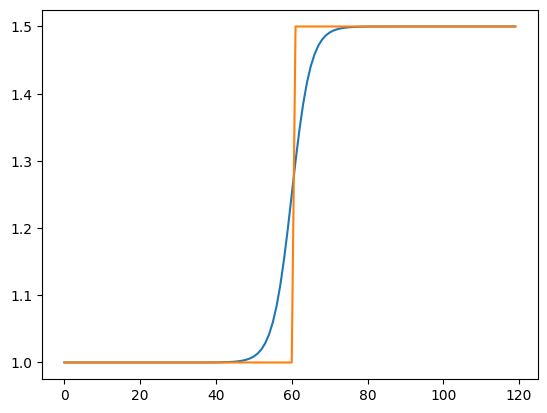

In [163]:
# plt.plot(n_sqr_well_list)
# plt.plot(n_free)
plt.plot(n_glass)
plt.plot(n_glass_sharp)

In [113]:
kxs, kzs

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]),
 array([31.41592654, 31.41592017, 31.41590107, 31.41586924, 31.41582468,
        31.41576738, 31.41569735, 31.41561459, 31.4155191 , 31.41541087,
        31.41528991, 31.41515622, 31.41500979, 31.41485063, 31.41467874,
        31.41449411, 31.41429675, 31.41408665, 31.41386382, 31.41362825,
        31.41337995, 31.41311892, 31.41284515, 31.41255864, 31.41225939,
        31.41194741, 31.41162269, 31.41128523, 31.41093504, 31.41057211,
        31.41019644, 31.40980802, 31.40940687, 31.40899298, 31.40856635,
        31.40812698, 31.40767486, 31.40721   , 31.4067324 , 31.40624206,
        31.40573897, 31.40522313, 31.40469456, 31.40415323, 31.40359916,
 

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [00:30<00:00, 6655.17it/s]


wavenumber (um^(-1)): 0.0


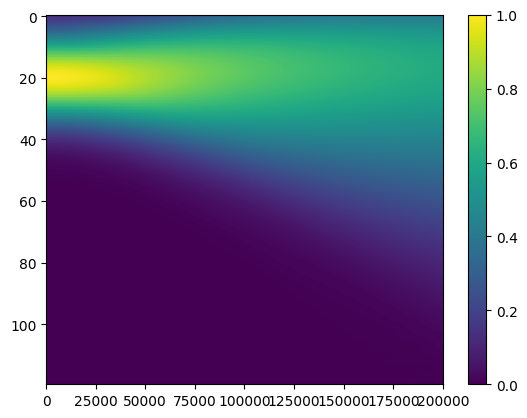

In [157]:
# uniform index of refraction n=1, no angle
# works as expected
idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_free, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [00:30<00:00, 6649.86it/s]


wavenumber (um^(-1)): 0.98


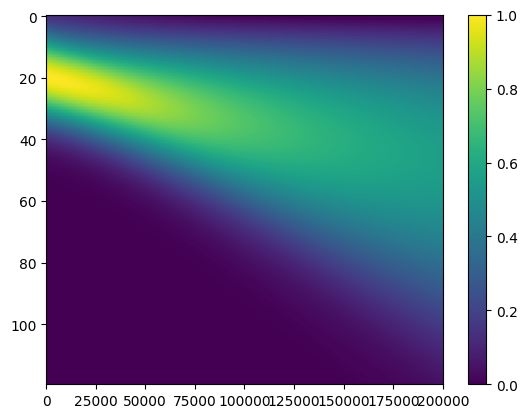

In [158]:
# uniform index of refraction, angle = 0.031
# works as expected

idx = -1

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_free, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:14<00:00, 7115.88it/s]


wavenumber (um^(-1)): 0.0


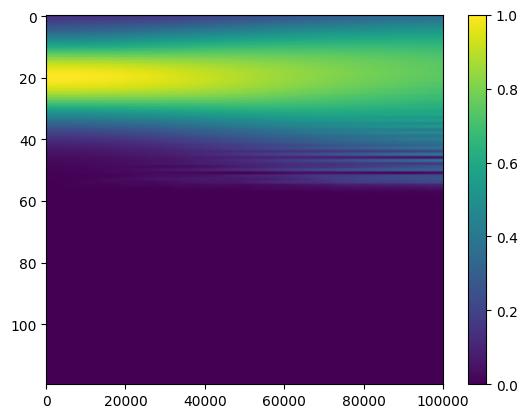

In [140]:
# air to glass, angle = 0 n_glass_sqr
# works

idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

 85%|█████████████████████████████████████████████████████████████▏          | 169928/200000 [00:27<00:04, 6084.62it/s]


169928
wavenumber (um^(-1)): 0.0


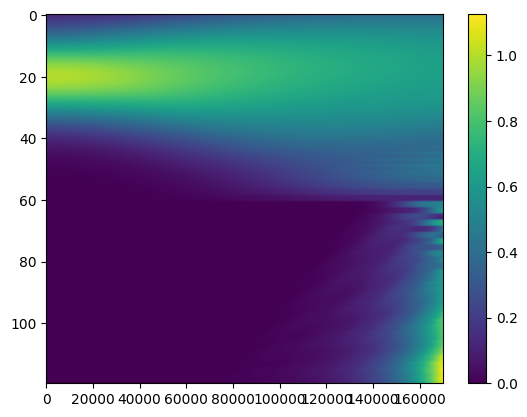

In [164]:
# air to glass, angle = 0 n_glass_sqr
# works

idx = 0

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass_sharp, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

 76%|██████████████████████████████████████████████████████▉                 | 152726/200000 [00:21<00:06, 7115.97it/s]


152726
wavenumber (um^(-1)): 0.98


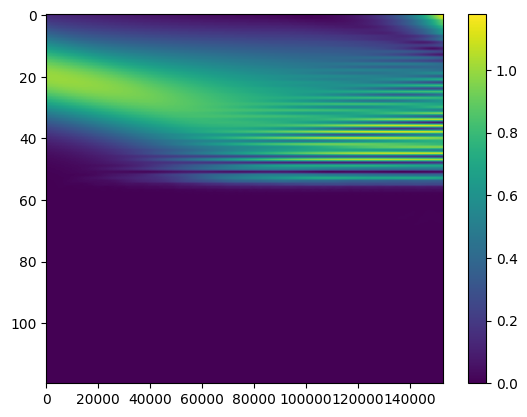

In [145]:
# air to glass, angle = 0.031
# doesn't work

idx = -1

kx = kxs[idx]
kz = kzs[idx]

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

 18%|█████████████                                                            | 35666/200000 [00:04<00:22, 7223.14it/s]


35666
wavenumber (um^(-1)): 5.455318392676835


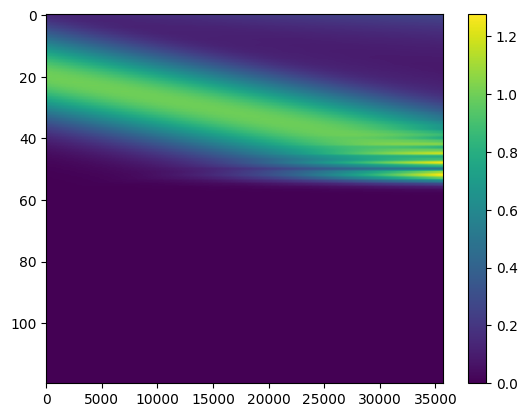

In [156]:
# air to glass, angle = 0.174 n_glass_sqr
# doesnt work

idx = -1

kx = big_kx
kz = big_kz

# make boundary condition
BC = get_BC_kx(x_0, x_max, x_step, kx, beam_center, waist)

# calculate propagation
E_grid0 = RK4GB_vec(BC, x_0, x_max, x_step, z_0, z_max, z_step, kz, n_glass, 10)

print(f"wavenumber (um^(-1)): {kx}")

plt.imshow(np.abs(E_grid0.T), aspect="auto")

plt.colorbar()

In [160]:
big_angle

0.17453292519943295